In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, precision_recall_curve, average_precision_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [3]:
from link.src.py_scripts.process_pals import begin_processing

In [4]:
random_seed = 17

# Data preparation

In [5]:
# True positive data
df_True_AluS = pd.read_csv('AluS3UTR.csv', index_col=0, sep=';')
df_True_AluY = pd.read_csv('AluY3UTR.csv', index_col=0, sep=';')
df_True_L1 = pd.read_csv('L13UTR.csv', index_col=0, sep=';')

In [6]:
df_True = pd.concat([df_True_AluS, df_True_AluY, df_True_L1]).reset_index(drop=True)

In [7]:
# True negative data
df_False = pd.read_csv('Random_non_transposon.csv', index_col=0, sep=';')

# Data analysis & visualisation

In [8]:
if df_True.shape[0] > df_False.shape[0]:
    df_True_n = df_True.sample(df_False.shape[0], random_state=random_seed)
    df_False_n = df_False
else:
    df_True_n = df_True
    df_False_n = df_False.sample(df_True.shape[0], random_state=random_seed)
    
X = pd.concat([df_True_n, df_False_n], ignore_index=True)
Y = pd.Series(np.append(np.full(df_True_n.shape[0], 1), 
                        np.full(df_False_n.shape[0], 0)))

# Getting rid of unneeded columns
X = X[X.columns[np.array(X.columns.map(lambda x: (len(x) > 4 or 'LP' in x or 'LB' in x or 'RB' in x) and 'GC' not in x), dtype='bool')]]

In [9]:
rf = RandomForestClassifier(n_jobs=6, n_estimators=2000)
folded_data = KFold(n_splits=5, random_state=random_seed, shuffle=True)

2018-11-28 16:43:42,524 - matplotlib.axes._base - DEBUG - update_title_pos
2018-11-28 16:43:42,530 - matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0 to DejaVu Sans ('/home/alexshein/.local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 2.050000.
2018-11-28 16:43:42,542 - matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/alexshein/.local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 2.050000.
2018-11-28 16:43:42,568 - matplotlib.font_manager - DEBUG - findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/home/alexshein/.local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000.
2018-11-28 

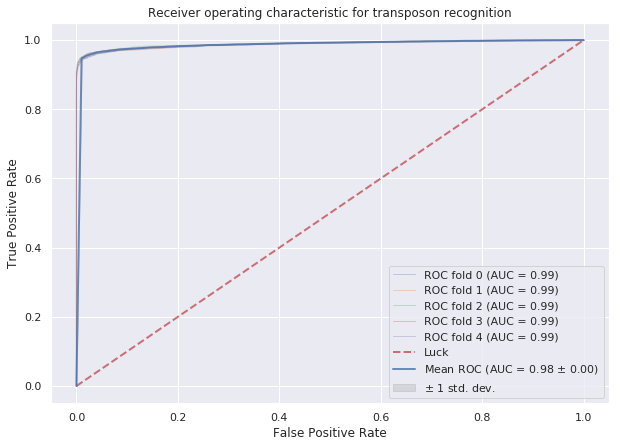

In [10]:
tprs = []
aucs, acc, rec, prec = [], [], [], []

mean_fpr = np.linspace(0, 1, 100)
i = 0

plt.figure(figsize=(10,7))
for k, (train, test) in enumerate(folded_data.split(X, Y)):
    probas_ = rf.fit(X.iloc[train], Y.iloc[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y.iloc[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    Y_pred = rf.predict(X.iloc[test])
    acc.append(accuracy_score(Y.iloc[test], Y_pred))
    prec.append(precision_score(Y.iloc[test], Y_pred))
    rec.append(recall_score(Y.iloc[test], Y_pred))
    plt.plot(
        fpr,
        tpr,
        lw=1,
        alpha=0.3,
        label='ROC fold %d (AUC = %0.2f)' % (k, roc_auc)
    )

plt.plot(
    [0, 1],
    [0, 1],
    linestyle='--',
    lw=2,
    color='r',
    label='Luck',
    alpha=.8
)
fpr, tpr, thresholds = roc_curve(Y.iloc[test], probas_[:, 1])

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color='grey',
    alpha=.2,
    label=r'$\pm$ 1 std. dev.'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for transposon recognition')
plt.legend(loc="lower right")
plt.show()

2018-11-28 16:45:40,503 - matplotlib.axes._base - DEBUG - update_title_pos
2018-11-28 16:45:40,569 - matplotlib.axes._base - DEBUG - update_title_pos
2018-11-28 16:45:40,590 - matplotlib.axes._base - DEBUG - update_title_pos
2018-11-28 16:45:40,602 - matplotlib.axes._base - DEBUG - update_title_pos


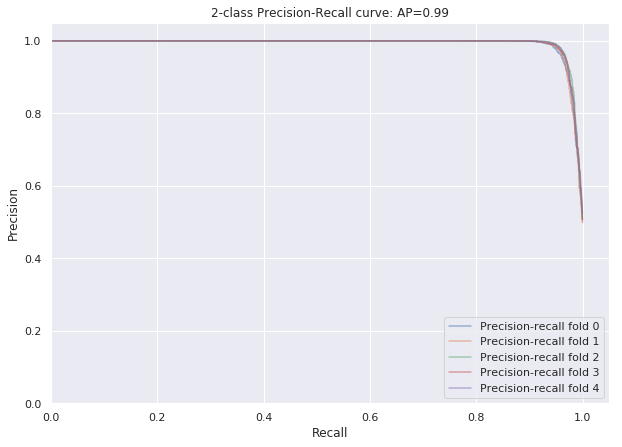

In [11]:
precisions = []
plt.figure(figsize=(10,7))
for k, (train, test) in enumerate(folded_data.split(X, Y)):
    probas_ = rf.fit(X.iloc[train], Y.iloc[train]).predict_proba(X.iloc[test])
    precision, recall, _ = precision_recall_curve(Y.iloc[test], probas_[:, 1])
    precisions.append(average_precision_score(Y.iloc[test], probas_[:, 1]))
    plt.step(
        recall,
        precision,
        alpha=0.5,
        where='post',
        label='Precision-recall fold {}'.format(k)
    )
average_precision = sum(precisions)/len(precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.legend(loc="lower right")
plt.show()

# AUC, Accuracy, Precision & Recall

In [12]:
mr = lambda x: np.round(np.mean(x), 4)
mr(aucs), mr(acc), mr(prec), mr(rec)

(0.989, 0.9671, 0.9922, 0.9416)

# Feature importance

2018-11-28 16:45:41,104 - matplotlib.axes._base - DEBUG - update_title_pos
2018-11-28 16:45:41,177 - matplotlib.axes._base - DEBUG - update_title_pos
2018-11-28 16:45:41,197 - matplotlib.axes._base - DEBUG - update_title_pos
2018-11-28 16:45:41,208 - matplotlib.axes._base - DEBUG - update_title_pos


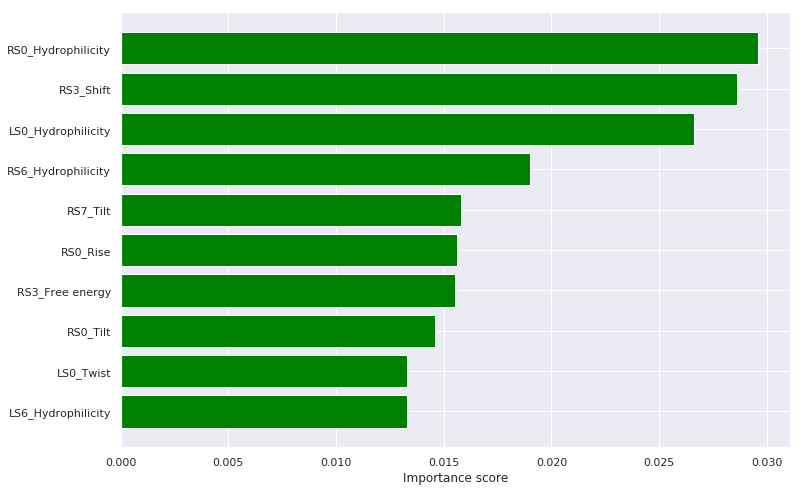

<Figure size 720x504 with 0 Axes>

In [13]:
N_to_print = 10
y_pos = range(N_to_print)
fig, ax = plt.subplots()
plt.figure(figsize=(10,7))

feature_importance = rf.feature_importances_.round(4)
feature_importance = zip(X.keys(), feature_importance)
feature_importance = np.array(sorted(feature_importance, key=lambda x:x[1], reverse=True))

ax.barh(y_pos, feature_importance[:N_to_print, 1].astype('float'), align='center', color='green')
ax.set_yticks(np.arange(N_to_print))
ax.set_yticklabels(feature_importance[:N_to_print, 0])
ax.invert_yaxis()
ax.set_xlabel('Importance score')

plt.show()

In [14]:
feature_importance = (rf.feature_importances_).round(4)
feature_importance = zip(X.keys(), feature_importance)
feature_importance = sorted(list(feature_importance), key=lambda x:x[1], reverse=True)
fi = pd.DataFrame(feature_importance, columns=['Feature_name', 'Feature_importance'])
fi.head(N_to_print)

,Feature_name,Feature_importance
0,RS0_Hydrophilicity,0.0296
1,RS3_Shift,0.0286
2,LS0_Hydrophilicity,0.0266
3,RS6_Hydrophilicity,0.0190
4,RS7_Tilt,0.0158
5,RS0_Rise,0.0156
6,RS3_Free energy,0.0155
7,RS0_Tilt,0.0146
8,LS0_Twist,0.0133
9,LS6_Hydrophilicity,0.0133


# Further generalization analysis block

In [15]:
CSV_FILE_SUBNAME_OBJECTS = "Alu_L1_vs_Shuffle" # "True_vs_False"
CSV_FILE_SUBNAME_TYPE = "Phys-Chem-Struct" # "50b.p._Stats" or "Stem-loop_Stats"
CSV_FILE_SUBNAME = "{0}__{1}".format(CSV_FILE_SUBNAME_OBJECTS, CSV_FILE_SUBNAME_TYPE)

In [16]:
pd.DataFrame.from_dict(
    {"Groups": [CSV_FILE_SUBNAME_OBJECTS],"fpr": [mr(fpr)], "tpr": [mr(tpr)], "precision": [mr(precision)], "recall": [mr(recall)]},
    orient='columns'
).to_csv("Stats__{0}.csv".format(CSV_FILE_SUBNAME), index=False)
pd.DataFrame(fi).to_csv("Feature_importance__{0}.csv".format(CSV_FILE_SUBNAME))